In [3]:
#| echo: false

import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import networkx as nx
import random
import pandas as pd
from shapely.geometry import Point, LineString


# Loading Shapefiles, showing them

load shapefiles of floorplan and landmarks


/Users/rarabsheiban/anaconda3/envs/landmark/lib/python3.10/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/vy/_ygtrw5x3l17_47gtq7vcqlw0000gp/T/ipykernel_13366/1509103015.py:16: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  sklet = gpd.overlay(floorplan_skeleton, floorplan_polygon, how='intersection')


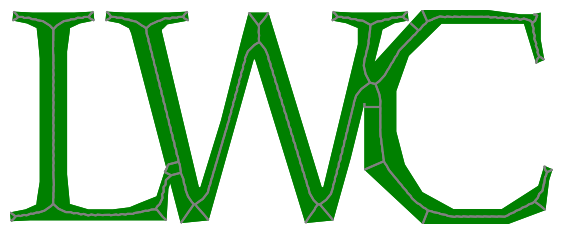

In [12]:
# floorplan_polygon = geopandas.read_file("data/shp/UTMpolygon.shp")
# sklet = geopandas.read_file("data/shp/skelet.shp")

floorplan_Bbox = gpd.read_file("Curated7/ICD_CalculatedV7.shp")
floorplan_border = gpd.read_file("Curated7/OneLetterV7.shp")
floorplan_skeleton = gpd.read_file("Curated7/SkelV7.shp")
floorplan_corner = gpd.read_file("Curated7/CornersV7.shp")

selected_landmarks = gpd.read_file("Geojson/selected_landmarks.shp")


# select the row that the distintc value is 'CBS_Average-Regular_Approach1'
floorplan_polygon = floorplan_border[floorplan_border['distinct'] == 'LWC_Average-Regular_Approach1']

# intersect skleton with the selected row
sklet = gpd.overlay(floorplan_skeleton, floorplan_polygon, how='intersection')


# Plot the two shapefiles
fig, ax = plt.subplots(figsize=(7, 7))
floorplan_polygon.plot(ax=ax, color='green')
sklet.plot(ax=ax, color='gray')

# Set the axis limits
ax.set_xlim(sklet.total_bounds[0], sklet.total_bounds[2])
ax.set_ylim(sklet.total_bounds[1], sklet.total_bounds[3])

# Show the plot
ax.axis('off')
plt.show()

# Converting Skeleton to Graph
Construct the primal graph. momepy automatically preserves all attributes
from GeoDataFrame and stores then as edge attributes.



In [13]:
G = momepy.gdf_to_nx(sklet, approach="primal", length="length")

same = 0
different = 0
due = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

i=1
while i < 10:  # Merge nodes that are closer than some meter
    for u, v, key, attr in list(G.edges(keys=True, data=True)):
        if attr['length'] < 100:
            # check if the edge still exists in the graph
            if G.has_edge(u, v):
                if G.degree(u) >= G.degree(v):
                    # merge the nodes
                    G = nx.contracted_nodes(G, u, v, self_loops=False)
                else:
                    # merge the nodes
                    G = nx.contracted_nodes(G, v, u, self_loops=False)

                # merge the nodes
                # G = nx.contracted_edge(G, (u, v), self_loops=False)

            else:
                due[i] = due[i] + 1
    i = i + 1

In [14]:
first=next(iter(G.nodes()))
first_value = G.nodes()[first]
print(first, first_value)

last=next(reversed(list(G.nodes())))
last_value = G.nodes()[last]
print(last, last_value)
#nx.shortest_path(G, G.nodes(), 5)

random.seed(10)
origin = random.choice(list(G.nodes()))
target = random.choice(list(G.nodes()))



(546846.2031523075, 1395216.2575374735) {'contraction': {(546815.0, 1395172.0): {}}}
(548675.3081281073, 1396350.9874551971) {'contraction': {(548675.0, 1396388.5161290322): {}}}


# Find and draw a route between origin and destination

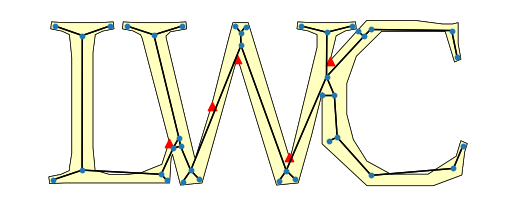

In [33]:
# find the shortest path between the first and last nodes
pos = {n: [n[0], n[1]] for n in list(G.nodes)}
path = nx.shortest_path(G, origin, target)
fig, ax = plt.subplots()
#plot with hex color code ffffbf with light border line
floorplan_polygon.plot(ax=ax, color='#ffffbf', edgecolor='black', linewidth=0.5)
# sklet.plot(ax=ax, color='gray')
selected_landmarks.plot(ax=ax, color='red', marker='^')


options = {
    "width": 1,
    "node_size": 10,
}

labeldict = {}
labeldict[origin] = ""
labeldict[target] = ""

nx.draw(G, pos, labels=labeldict, with_labels=True, ax=ax, **options)
path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
# nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=3, ax=ax)
plt.show()

# Plot the two shapefiles
# fig, ax = plt.subplots(figsize=(7, 7))

# Set the axis limits
ax.set_xlim(sklet.total_bounds[0], sklet.total_bounds[2])
ax.set_ylim(sklet.total_bounds[1], sklet.total_bounds[3])


# Show the plot of the shortest path over the previous plots
ax.axis('off')
# add a legend, make sure it is below
ax.legend(["Selected Slot", "Decision Point", "Navigation Graph"], loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)


plt.show()
fig.savefig("shortest_path.png", dpi=300)

# generate route instructions for the path
## 'styles' :
* **Turn-based**: route instruction using cardinal or inter-cardinal turns at the decision points
* **Landmark**: uses *Go Toward* if the landmark is within a threshold proximity of next intersection (coming decision point), also uses *Pass* if a landmark is located at an edge
* **Hybrid**: generate route instruction including both turn-based and landmark components

## 'grammar' :
* **4sector**: Equiangular cardinal egocentric directions
* **6sector**: Selective angles with more focus on forward directions
* **8sector**: Equiangular cardinal and inter-cardinal egocentric directions
* **Klipple**: Statistically specified cardinal and inter-cardinal egocentric directions


Each node is encoded by its coordinates, which allows us to use them
in plotting.

